In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix
from gensim.corpora import Dictionary
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
import spacy
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from gensim.models import LdaModel
import pyLDAvis.gensim_models
from sklearn.model_selection import GridSearchCV
import torch.nn as nn
from tqdm.notebook import tqdm
import random
import numpy as np
import torch
from wordcloud import WordCloud

In [3]:
!rm -rf Emotions-dataset-for-NLP
!git clone https://github.com/repeating/Emotions-dataset-for-NLP.git
import sys
sys.path.append('Emotions-dataset-for-NLP')


data = []
with open('Emotions-dataset-for-NLP/datasets/text.txt') as f:
    for line in f.readlines():
        text, emotion = line.strip().split(';')
        data.append({'text': text, 'emotion': emotion})
data = pd.DataFrame(data)

Cloning into 'Emotions-dataset-for-NLP'...
remote: Enumerating objects: 36, done.
remote: Counting objects: 100% (36/36), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 36 (delta 9), reused 27 (delta 5), pack-reused 0
Unpacking objects: 100% (36/36), done.


In [4]:
print('number of samples:', len(data))
data.head(10)

number of samples: 20000


,text,emotion
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger
5,ive been feeling a little burdened lately wasn...,sadness
6,ive been taking or milligrams or times recomme...,surprise
7,i feel as confused about life as a teenager or...,fear
8,i have been with petronas for years i feel tha...,joy
9,i feel romantic too,love


number of different classes: 6
set of unique emotions: ['sadness' 'anger' 'love' 'surprise' 'fear' 'joy']


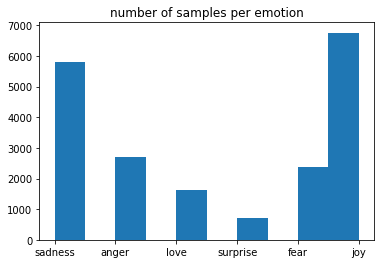

In [5]:
n_classes = len(set(data['emotion']))
print('number of different classes:', n_classes)
print('set of unique emotions:', data['emotion'].unique())
plt.hist(data['emotion'])
plt.title('number of samples per emotion')
plt.show()

In [6]:
def text_reformat(text):
    """lowercase without punctuation"""
    import re
    return re.sub(r'[^\w\s]', '', text.lower())

print('Removing punctuation and converting to lowercase..')
data['text'] = data['text'].apply(text_reformat)

Removing punctuation and converting to lowercase..


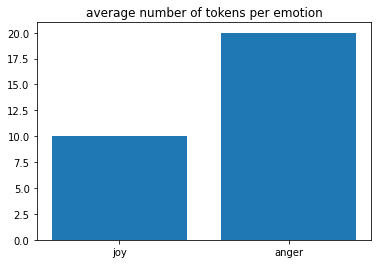

In [7]:
plt.title('average number of tokens per emotion')
plt.bar(['joy', 'anger'], [10, 20])
plt.show()

In [8]:
"""tokenize and lemmatize text, and remove stopwords"""
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
all_stopwords = spacy.lang.en.stop_words.STOP_WORDS

def tokens(s: str):
    return [t.text for t in nlp(s) if t.text not in all_stopwords]

text_tokens = [tokens(t) for t in tqdm(data['text'], desc="tokenize")]
data.insert(2, 'text_tokens', text_tokens)

example = "nick likes to play football however he is not too fond of tennis"
example_tokens = tokens(example)

print('Before tokenizing:', example)
print('After tokenizing:', example_tokens)

/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:126: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


tokenize:   0%|          | 0/20000 [00:00<?, ?it/s]

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: Sele

Before tokenizing: nick likes to play football however he is not too fond of tennis
After tokenizing: ['nick', 'likes', 'play', 'football', 'fond', 'tennis']


/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):
/usr/local/lib/python3.7/dist-packages/catalogue.py:138: DeprecationWarning: SelectableGroups dict interface is deprecated. Use select.
  for entry_point in AVAILABLE_ENTRY_POINTS.get(self.entry_point_namespace, []):


average number of tokens in a document: 8.3312


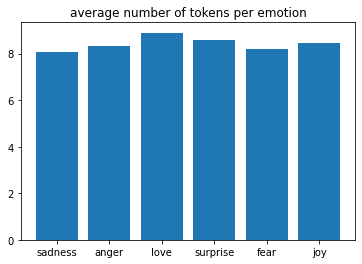

In [9]:
avg_num_tokens = sum(len(t) for t in text_tokens) / len(text_tokens)

print('average number of tokens in a document:', avg_num_tokens)

avg_tokens = []
for emotion in data['emotion'].unique():
    df = data[data['emotion'] == emotion]
    avg_tokens.append(sum(len(x) for x in df['text_tokens'].tolist()) / len(df))

plt.title('average number of tokens per emotion')
plt.bar(data['emotion'].unique(), avg_tokens)
plt.show()

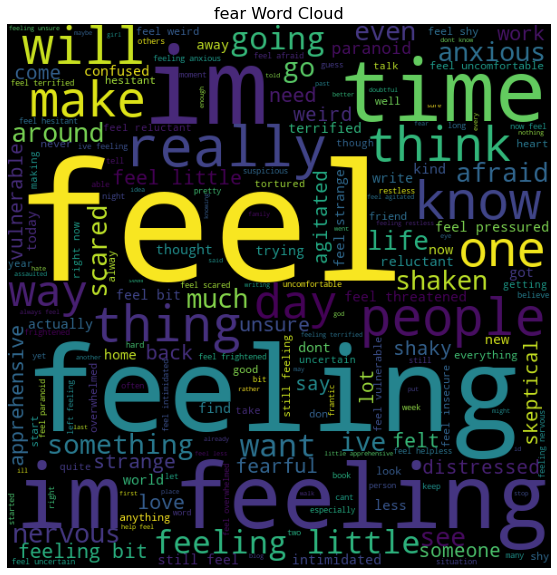

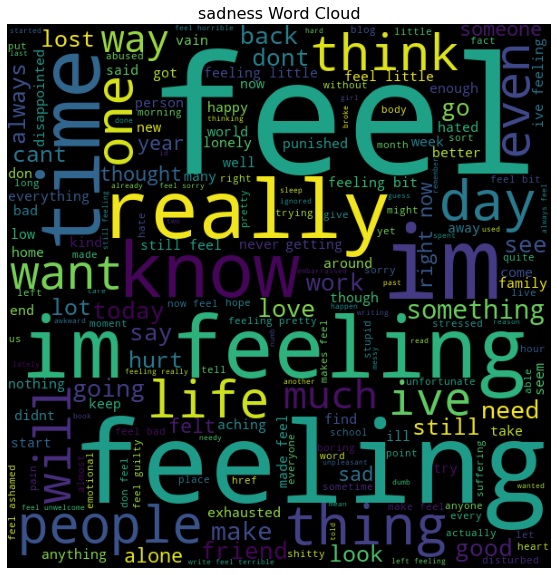

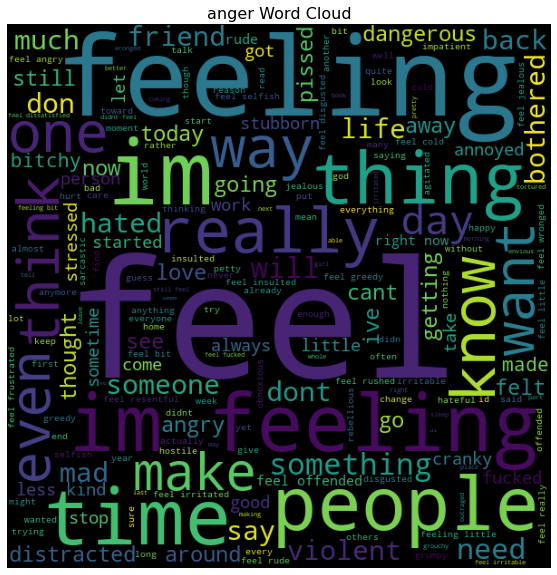

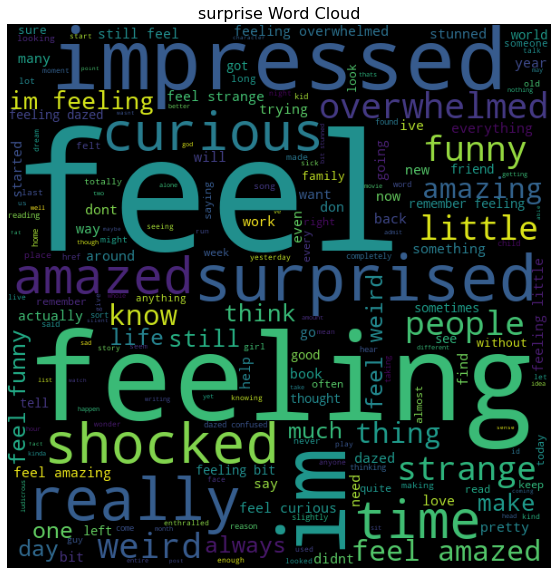

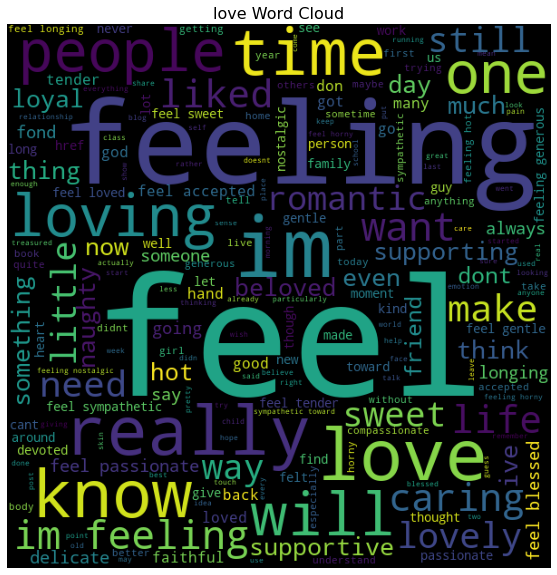

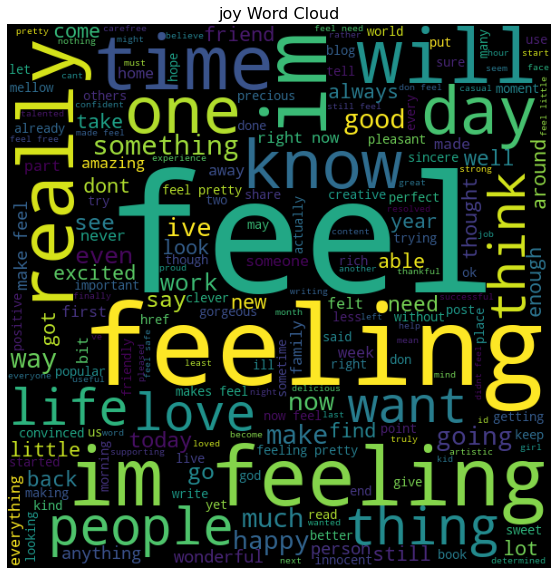

In [10]:
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
    
for emotion in set(data['emotion']):
    text = ' '.join([sentence for sentence in data.loc[data['emotion'] == emotion,'text']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

In [11]:
# Create a dictionary representation of the documents.
dictionary = Dictionary(text_tokens)

# Filter out words that occur less than in 5 documents, or more than in 50% of the documents.
dictionary.filter_extremes(no_below=5, no_above=0.5)
print("dictionary word with index 20:", dictionary[20])

dictionary word with index 20: little


In [12]:
# Convert tokenized documents into bag-of-words (BOW) representation: (word index, word count)
corpus = [dictionary.doc2bow(doc) for doc in text_tokens]
print("Example of BOW representation:", corpus[0])
print('Number of unique tokens:', len(dictionary))
print('Number of documents:', len(corpus))#%%

Example of BOW representation: [(0, 1), (1, 1)]
Number of unique tokens: 3648
Number of documents: 20000


In [13]:
# train LDA model
lda = LdaModel(
    corpus,  # documents in BOW format
    id2word=dictionary.id2token,  # id -> word mapping to make topics interpretable
    num_topics=6,  # desired number of topics
    passes=30,  # number of iterations
)

# look at the topics
print("LDA topics:")
lda.print_topics()

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt * logsumexp(Elogthetad + Elogbeta[:, int(id)]) for id, cnt in doc)
/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1077: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  score += np.sum(cnt

LDA topics:


[(0,
  '0.039*"feeling" + 0.031*"like" + 0.024*"ve" + 0.017*"love" + 0.011*"nt" + 0.010*"life" + 0.009*"time" + 0.009*"feels" + 0.007*"feelings" + 0.007*"s"'),
 (1,
  '0.063*"feeling" + 0.018*"like" + 0.013*"little" + 0.011*"nt" + 0.010*"morning" + 0.009*"day" + 0.008*"bit" + 0.008*"night" + 0.007*"passionate" + 0.007*"started"'),
 (2,
  '0.048*"like" + 0.016*"nt" + 0.014*"s" + 0.013*"know" + 0.012*"people" + 0.010*"think" + 0.009*"love" + 0.008*"way" + 0.008*"want" + 0.007*"world"'),
 (3,
  '0.130*"feeling" + 0.127*"m" + 0.027*"little" + 0.019*"bit" + 0.014*"today" + 0.012*"like" + 0.012*"going" + 0.012*"pretty" + 0.011*"ve" + 0.008*"week"'),
 (4,
  '0.066*"t" + 0.045*"feeling" + 0.029*"don" + 0.020*"like" + 0.015*"know" + 0.014*"http" + 0.012*"href" + 0.011*"want" + 0.010*"s" + 0.009*"hate"'),
 (5,
  '0.043*"nt" + 0.027*"like" + 0.017*"know" + 0.017*"people" + 0.017*"m" + 0.015*"want" + 0.012*"sure" + 0.012*"time" + 0.012*"feeling" + 0.010*"right"')]

In [14]:
import warnings
warnings.filterwarnings('ignore')

pyLDAvis.enable_notebook()
pyLDAvis.gensim_models.prepare(lda, corpus, dictionary)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.151984  0.065019       1        1  19.534110
3     -0.234736  0.077674       2        1  18.343335
2      0.246056  0.069944       3        1  17.753326
0      0.010220  0.075566       4        1  16.581513
1     -0.172824  0.057129       5        1  14.286463
4     -0.000700 -0.345332       6        1  13.501253, topic_info=         Term         Freq        Total Category  logprob  loglift
10          m  3513.000000  3513.000000  Default  30.0000  30.0000
5     feeling  6304.000000  6304.000000  Default  29.0000  29.0000
182         t  1182.000000  1182.000000  Default  28.0000  28.0000
232       don   524.000000   524.000000  Default  27.0000  27.0000
20     little   893.000000   893.000000  Default  26.0000  26.0000
...       ...          ...          ...      ...      ...      ...
125    people   117.270119   833.512178   Topic6  -5.0254   0.0412
53      think   113.497006   695.222835   Topic6  -5.0581   0.1899
228       way   100.690384   537.469688   Topic6  -5.1779   0.3276
1403     went    84.707629   149.709001   Topic6  -5.3507   1.4329
681     sorry    80.552796   113.308485   Topic6  -5.4010   1.6612

[344 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
363       5  0.984455     aching
1067      1  0.242724   actually
1067      2  0.489943   actually
1067      4  0.175301   actually
1067      5  0.094393   actually
...     ...       ...        ...
37        5  0.244506       year
39        1  0.159339      years
39        4  0.590144      years
39        5  0.241959      years
1346      5  0.992827  yesterday

[435 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 4, 3, 1, 2, 5])

In [15]:
X = data['text']

le = LabelEncoder()
y = le.fit_transform(data['emotion'])
class_labels = [le.inverse_transform([i])[0] for i in range(n_classes)]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33)

print('X_train shape:', X_train.shape)
print('X_test shape:', X_test.shape)

X_train shape: (13400,)
X_test shape: (6600,)


In [16]:
vec = TfidfVectorizer(stop_words='english', max_features = 3000, ngram_range = (1, 2))
vec.fit(X_train)
X_train_vecs = vec.transform(X_train).todense().tolist()
X_test_vecs = vec.transform(X_test).todense().tolist()

In [17]:
clf = SGDClassifier(max_iter=100, penalty='elasticnet')

clf.fit(X_train_vecs, y_train)
print("Accuracy score on train:", accuracy_score(y_train, clf.predict(X_train_vecs)))
print("Accuracy score on test:", accuracy_score(y_test, clf.predict(X_test_vecs)))

Accuracy score on train: 0.922089552238806
Accuracy score on test: 0.8975757575757576


In [19]:
parameters = {
    'penalty': ['l1', 'l2', 'elasticnet'],
    'alpha': [0.001, 0.0001, 0.00001],
    'max_iter': [10, 100, 1000]
}

grid_search = GridSearchCV(SGDClassifier(), parameters, scoring='accuracy')
grid_search.fit(X_train_vecs, y_train)

print("Accuracy score on train:", accuracy_score(y_train, grid_search.predict(X_train_vecs)))
print("Accuracy score on test:", accuracy_score(y_test, grid_search.predict(X_test_vecs)))
print("The best model parameters are:", grid_search.best_estimator_)

Accuracy score on train: 0.937910447761194
Accuracy score on test: 0.8956060606060606
The best model parameters are: SGDClassifier(max_iter=100, penalty='elasticnet')


In [20]:
class ClassificationRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.hh = nn.Linear(hidden_size, hidden_size)
        self.xh = nn.Linear(input_size, hidden_size)
        self.hy = nn.Linear(hidden_size, output_size)

        self.relu = nn.ReLU()
        self.softmax = nn.LogSoftmax(dim=1)

        self.hidden_size = hidden_size

    def forward(self, x, h):
        hidden = self.relu(self.hh(h) + self.xh(x))
        output = self.softmax(self.hy(hidden))
        return output, hidden

    def h0(self):
        return torch.zeros(1, self.hidden_size)

In [21]:
def process_sequence_classification(rnn, target_tensor, input_tensor, learning_rate):
    rnn.zero_grad()
    hidden = rnn.h0()

    for i in range(input_tensor.size()[0]):
        output, hidden = rnn(input_tensor[i], hidden)

    loss_function = nn.NLLLoss()
    loss = loss_function(output, target_tensor)
    loss.backward()

    with torch.no_grad():
        for parameter in rnn.parameters():
            parameter -= learning_rate * parameter.grad

    return loss.item()

In [22]:
random.seed(0)

n_hidden = 64
rnn = ClassificationRNN(len(X_train_vecs[0]), n_hidden, len(set(y_train)))

n_iters = 13400
print_every = 1000

# Keep track of losses for plotting
all_losses = []
iterations = []
losses = []

for i in tqdm(range(1, n_iters + 1)):
    # sample categories uniformly
    idx = random.randint(0, len(X_train) - 1)
    
    input_tensor, target_tensor = torch.tensor([X_train_vecs[idx]]), torch.tensor([y_train[idx]])
    
    # process sequence: update RNN weights and compute loss
    loss = process_sequence_classification(rnn, target_tensor, input_tensor, 0.0005)
    all_losses.append(loss)

    if i % print_every == 0:
        iterations.append(i)
        avg_loss = np.mean(all_losses[-print_every:])
        losses.append(avg_loss)
        print(f"iteration {i}: loss {avg_loss}")

  0%|          | 0/13400 [00:00<?, ?it/s]

iteration 1000: loss 1.78021839761734
iteration 2000: loss 1.727197911143303
iteration 3000: loss 1.701496637582779
iteration 4000: loss 1.6766810911893844
iteration 5000: loss 1.6402867636680603
iteration 6000: loss 1.6203392403125763
iteration 7000: loss 1.6097142122983932
iteration 8000: loss 1.6069456156492232
iteration 9000: loss 1.5947728949785231
iteration 10000: loss 1.6046628021001816
iteration 11000: loss 1.580740912079811
iteration 12000: loss 1.5751900874376297
iteration 13000: loss 1.6095202012062073


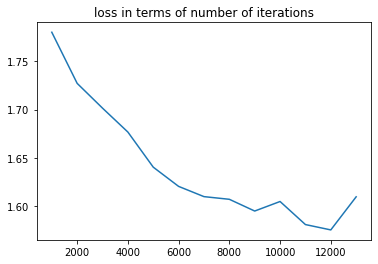

In [23]:
plt.title('loss in terms of number of iterations')
plt.plot(iterations, losses)
plt.show()

In [24]:
def evaluate(rnn, name_tensor):
    hidden = rnn.h0()

    for i in range(name_tensor.size()[0]):
        output, hidden = rnn(name_tensor[i], hidden)
    
    return output

def predict(input_vec, n_predictions=1):
    with torch.no_grad():
        output = evaluate(rnn, torch.tensor(input_vec))

        # Get top N categories
        topv, topi = output.topk(n_predictions, 1, True)
        predictions = []

        for i in range(n_predictions):
            value = topv[0][i].item()
            category_index = topi[0][i].item()
            print('(%.2f) %s' % (value, le.inverse_transform([category_index])))
            predictions.append([value, le.inverse_transform([category_index])])